### Tissue Tutorial

In this tutorial we show the results of our ablation study over spatial features and single-cell resolution for graph neural networks (GNN) that predict tumor phenotypes from spatial graphs with categorical cell type node features on a colorectal cancer CODEX dataset.


**Dataset:**
The dataset consists of 140 images from 35 patients (4 images per patient) from two colorectal cancer tumor classes:

    1. Crohn’s-like reaction (CLR) and,
    2. Diffuse inflammatory infiltration (DII)

during the tutorial we refer to CLR class as grade 1 and DII class as grade 2.

**Models:**

#### A. GNN models:

    1. Graph convolutional networks (GCN)
    2. Graph isomorphism networks (GIN)
    3. [optional] GCN with self-supervision (GCNSS)

#### B. Baseline models

    Scenario 1: Mean node features models
    
        1. Multi-Layer Preceptron (MLP)
        2. Random Forest
        3. Logistic regression
    
    Scenario 2: Single cell/cell type models
    
        1. Multi-instance (MI) on single cell level
        2. Aggregation multi-instance (AGG) on cell type level - only in case of molecular feature space
    
    Scenario 3: Spatial models

        1. Graph neural network without node features
        2. Node degree models (random forest and/or logistic regression)
        3. Dispersion model 

**In this tutorial we cover:**

1. Models performance comparison
2. Sample embeddings interpretation
3. Gradient based interpretation




### 1. Models performance comparison

#### Loading trained models


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sklearn.metrics
from sklearn.preprocessing import quantile_transform
#from sksurv.metrics import concordance_index_censored

from tissue.train.summaries import GridSearchContainer
from tissue.interpretation.interpreter import Interpreter

from typing import Dict, List, Tuple, Union


import scanpy as sc
sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings('ignore')

In [3]:
DATASET="CODEX" # dataset name 
FEATURE_SPACE="celltype" # feature space - either cell type or molecualr
CELL_TYPE_COARSENESS="binary" # coarseness - either binary [immune vs non immune] or fine annotation

In [4]:
BASE_DIR = "" # path to trained models
DATA_DIR = "" # path to data

In [5]:
## Define train models paths


# GNN models
base_path_gcn = f"{BASE_DIR}/GCN/"
base_path_gin = f"{BASE_DIR}/GIN/"

# Baselin models

### scenario 3
base_path_disp = f"{BASE_DIR}/DISP/"
base_path_node_degree = f"{BASE_DIR}/NODEDEGREE/

### scenario 2
base_path_mi = f"{BASE_DIR}/MI/"
base_path_agg = f"{BASE_DIR}/AGG/"

### scenario 1
base_path_reg = f"{BASE_DIR}/REG/"
base_path_regmean = f"{BASE_DIR}/REGMEAN/"
base_path_rfmean = f"{BASE_DIR}/RFMEAN/"

In [6]:
source_path={
    
    f"GCN_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_gcn,
    f"GIN_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_gin,
    
    f"DISP_GROUP_{FEATURE_SPACE}_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_disp,
    f"NODEDEGREE_GROUP_{FEATURE_SPACE}_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_node_degree,
    
    f"MI_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_mi,
    f"AGG_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_agg,
    
    
    f"REG_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_reg,
    f"REGMEAN_GROUP_{FEATURE_SPACE}_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_regmean,
    f"RFMEAN_GROUP_{FEATURE_SPACE}_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_rfmean,

}

gs_ids = list(source_path.keys())

In [7]:
container = GridSearchContainer(
    source_path=source_path,
    gs_ids=gs_ids
)
container.load_gs(recompute_evaluation=False)

loaded 2304271038_GCN_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
loaded 2304271045_GCNSS_GROUP_CELLTYPE_binary_schuerch_SS_TARGET: 6 runs with 9-fold cross validation
loaded 2304271045_GIN_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
loaded 230531_GCN_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
loaded 230531_GCNSS_GROUP_CELLTYPE_binary_schuerch_SS_TARGET: 6 runs with 9-fold cross validation
loaded 230531_GIN_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
loaded 2304271045_MI_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
loaded 2304271045_REG_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
loaded 2305111244_REGMEAN_GROUP_CELLTYPE_binary_schuerch_: 1 runs with 9-fold cross validation
loaded 2305111244_RFMEAN_GROUP_CELLTYPE_binary_schuerch_: 1 runs with 9-fold cross validation
loaded 2

**Models comparison**

In [9]:
#sns.set_palette("colorblind")
custom_palette = ["#36454F", "#4682B4", "#FFDB58"]


# Set the Seaborn color palette
sns.set_palette(custom_palette)

kwargs = {
    'partition_select': 'train',
    'metric_select': 'loss',
    'cv_mode': 'mean',
    'param_hue': 'models',
    'param_x': ['model_groups'],
    'suffix': '.pdf',
    'panel_width': 10,
    'panel_height': 7,
    'ttest': True,
    'feature_space': False,
    'show_swarm': False,
}

selected ['model_groups']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEAN_NN v.s. MI_NN: t-test independent samples, P_val=9.325e-01 stat=8.601e-02
GCN_NN v.s. GIN_NN: t-test independent samples, P_val=2.435e-04 stat=4.695e+00
DISP_RF v.s. GCN_NN: t-test independent samples, P_val=2.125e-05 stat=-5.927e+00
MI_NN v.s. DISP_RF: t-test independent samples, P_val=6.971e-02 stat=1.944e+00
MI_NN v.s. GCN_NN: t-test independent samples, P_val=7.676e-03 stat=-3.048e+00
MEAN_NN v.s. GCN_NN: t-test independent samples, P_val=1.227e-02 stat=-2.822e+00


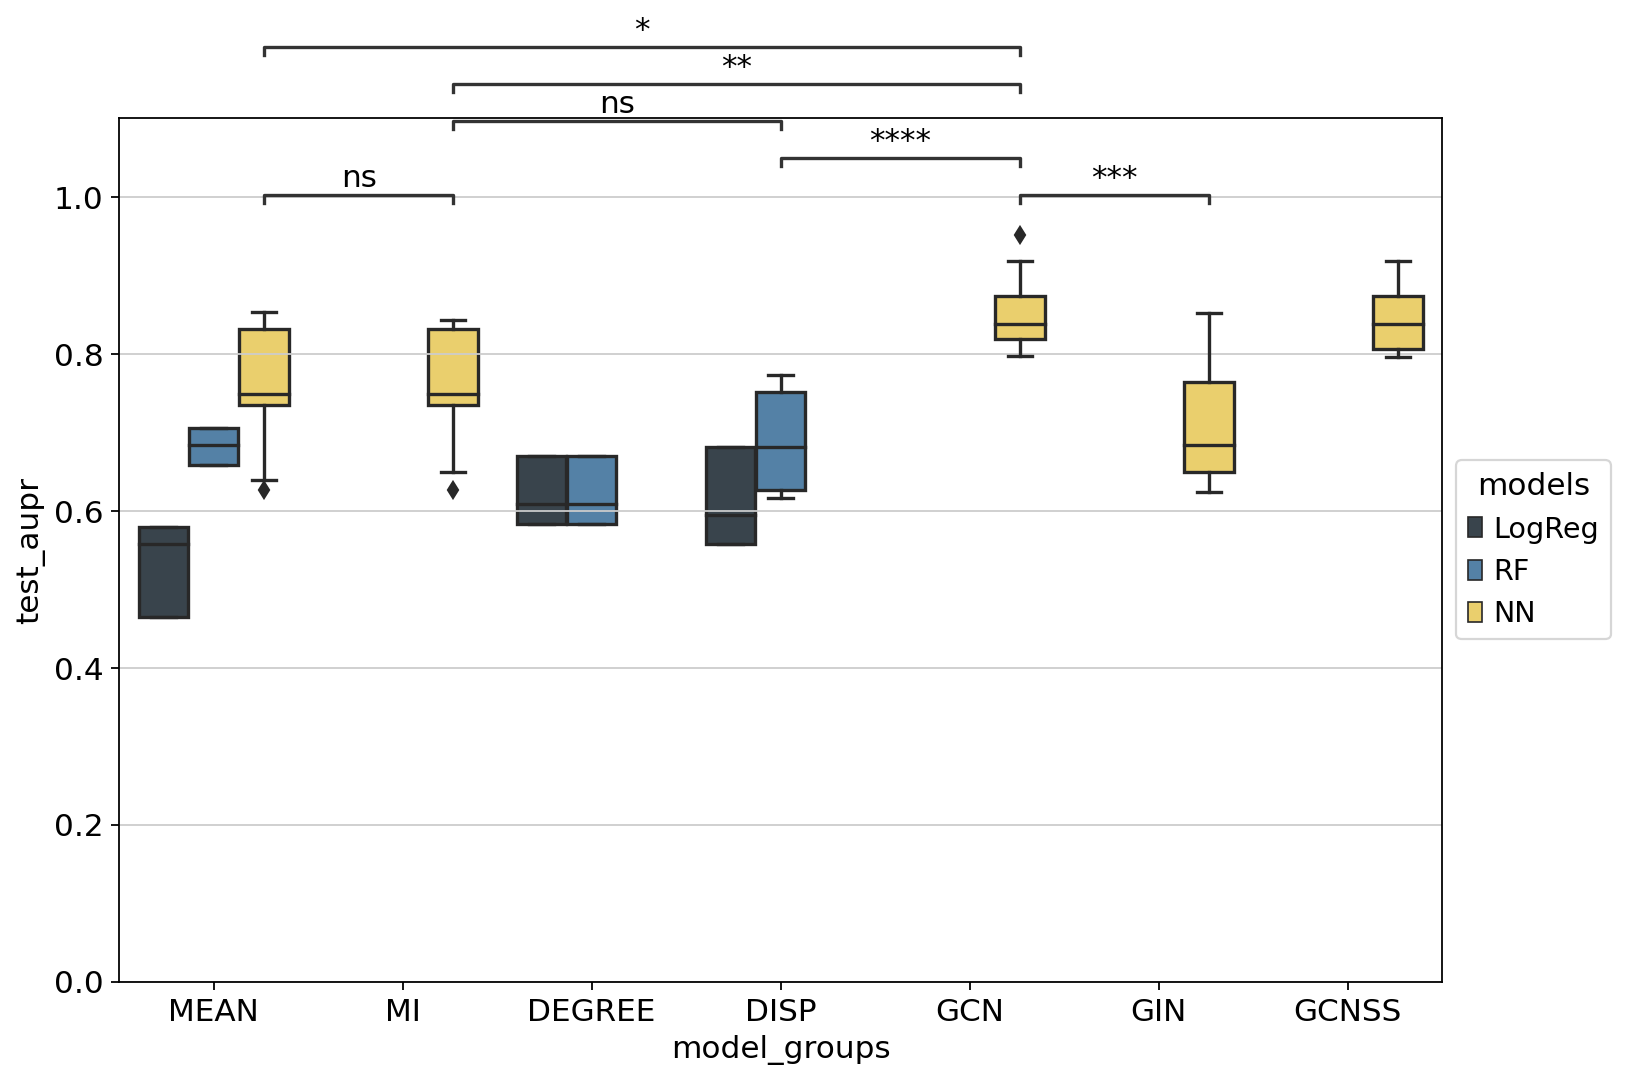

In [10]:
for metric in ['aupr']:
    container.plot_best_model_by_hyperparam(
        partition_show="test",
        metric_show=metric,
        **kwargs
    )

### 2. Sample  embeddings interpretation

loaded 230531_GIN_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation
dataset='schuerch'
self.runparams['radius']=50
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.
infered cell type coarseness: binary
Loading data from buffer
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


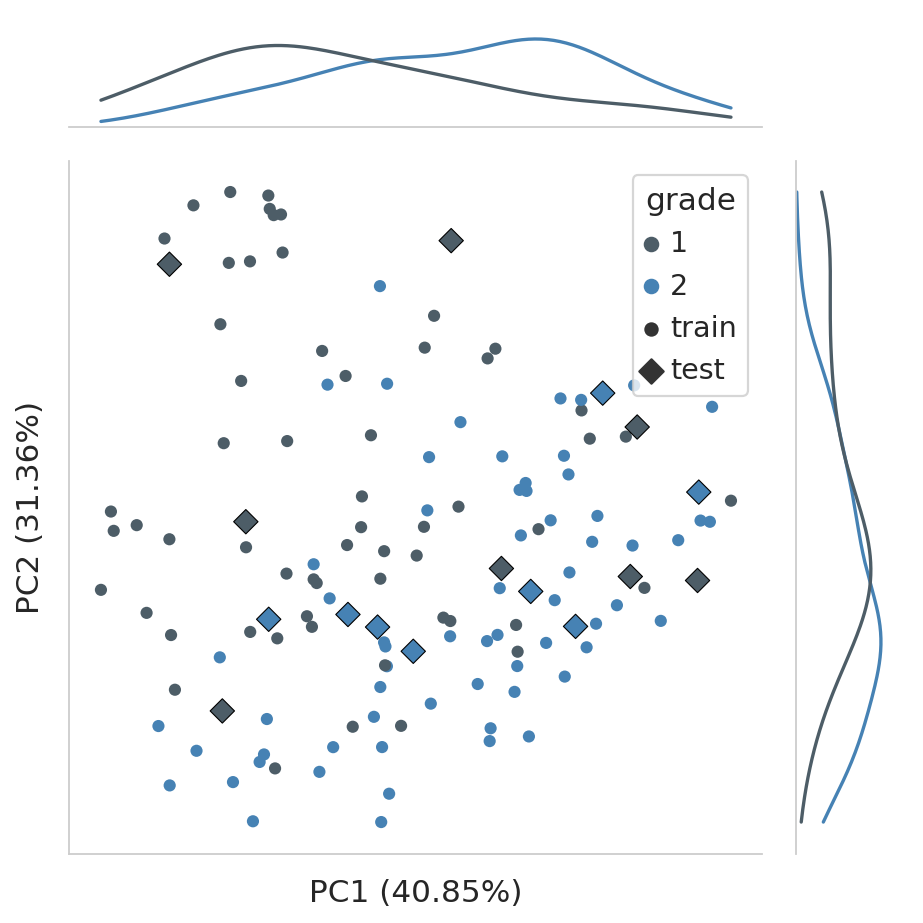

In [11]:
# specify graph neural network model one wants to interpret
model_class = "GIN" # from GIN, GCN, GCNSS

source_path_gnn={
    f"{model_class}_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_gin,
}
gs_ids_gnn = list(source_path_gnn.keys())


# 
container_gnn = GridSearchContainer(
    source_path=source_path_gnn,
    gs_ids=source_path_gnn,
)
container_gnn.load_gs()
gs_id, model_id, test_cv, val_cv = container_gnn.get_best_model_id(
    partition_select='train', # either - train, val, or test
    metric_select='loss'
)


interpreter = Interpreter(
    gs_path=[value for key, value in source_path.items() if f'_{model_class}_' in key][0],
    gs_id=gs_id,
    model_id=model_id,
    test_cv=test_cv,
    val_cv=val_cv,
    data_path=DATA_DIR,
)

interpreter.plot_graph_embedding(
    embedding_method='pca',
    data_key='codex',
)

Here grade 1 are CLR patients and grade 2 are DII patients.

### 3. Gradient based Interpretation

The following analysis is done on single image level

In [13]:
from tissue.interpretation.interpreter import Interpreter

In [15]:
model_class = "GCN"


source_path_gcn={
   
    f"GCN_GROUP_CELLTYPE_{CELL_TYPE_COARSENESS}_{DATASET}": base_path_gcn,
    
}

gs_ids_gcn = list(source_path_gcn.keys())

In [17]:
container_gcn = GridSearchContainer(
    source_path={key: value for key, value in source_path_gcn.items() if f'_{model_class}_' in key},
    gs_ids=[key for key in source_path_gcn.keys() if f'_{model_class}_' in key],
)
container_gcn.load_gs()
gs_id, model_id, test_cv, val_cv = container_gcn.get_best_model_id(partition_select='train')
container_gcn.get_info(gs_id=gs_id, model_id=model_id)

loaded 230531_GCN_GROUP_CELLTYPE_binary_schuerch_NONE_TARGET: 6 runs with 9-fold cross validation


In [20]:
# loading interpreters - for different cell type coarseness for plotting

interpreter_fine = Interpreter(
    gs_path=[value for key, value in source_path.items() if f'_{model_class}_' in key][0],
    gs_id=gs_id,
    model_id=model_id,    
    test_cv=test_cv,
    val_cv=val_cv,
    data_path=DATA_DIR,
    cell_type_coarseness="fine",
    reload_raw=True,
)


interpreter = Interpreter(
    gs_path=[value for key, value in source_path.items() if f'_{model_class}_' in key][0],
    gs_id=gs_id,
    model_id=model_id,    
    test_cv=test_cv,
    val_cv=val_cv,
    data_path=DATA_DIR,
    reload_raw=True
)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 21 distinct celltypes.
infered cell type coarseness: binary
Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 2 distinct celltypes.
Test dataset: 16 images from 4 patients.
Training dataset: 124 images from 31 patients.
Validation dataset: 0 images from 0 patients.



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


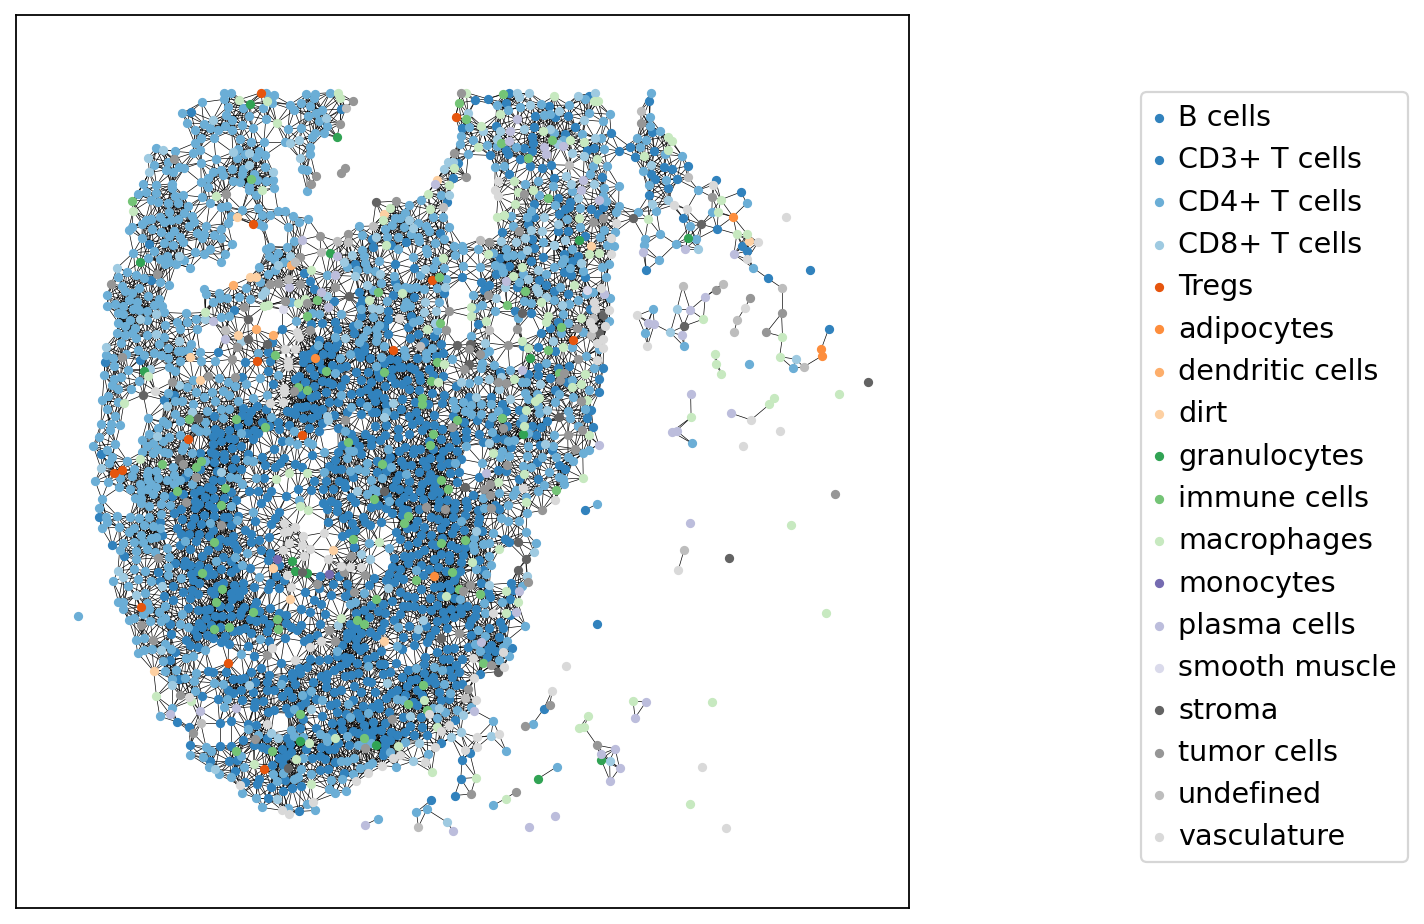

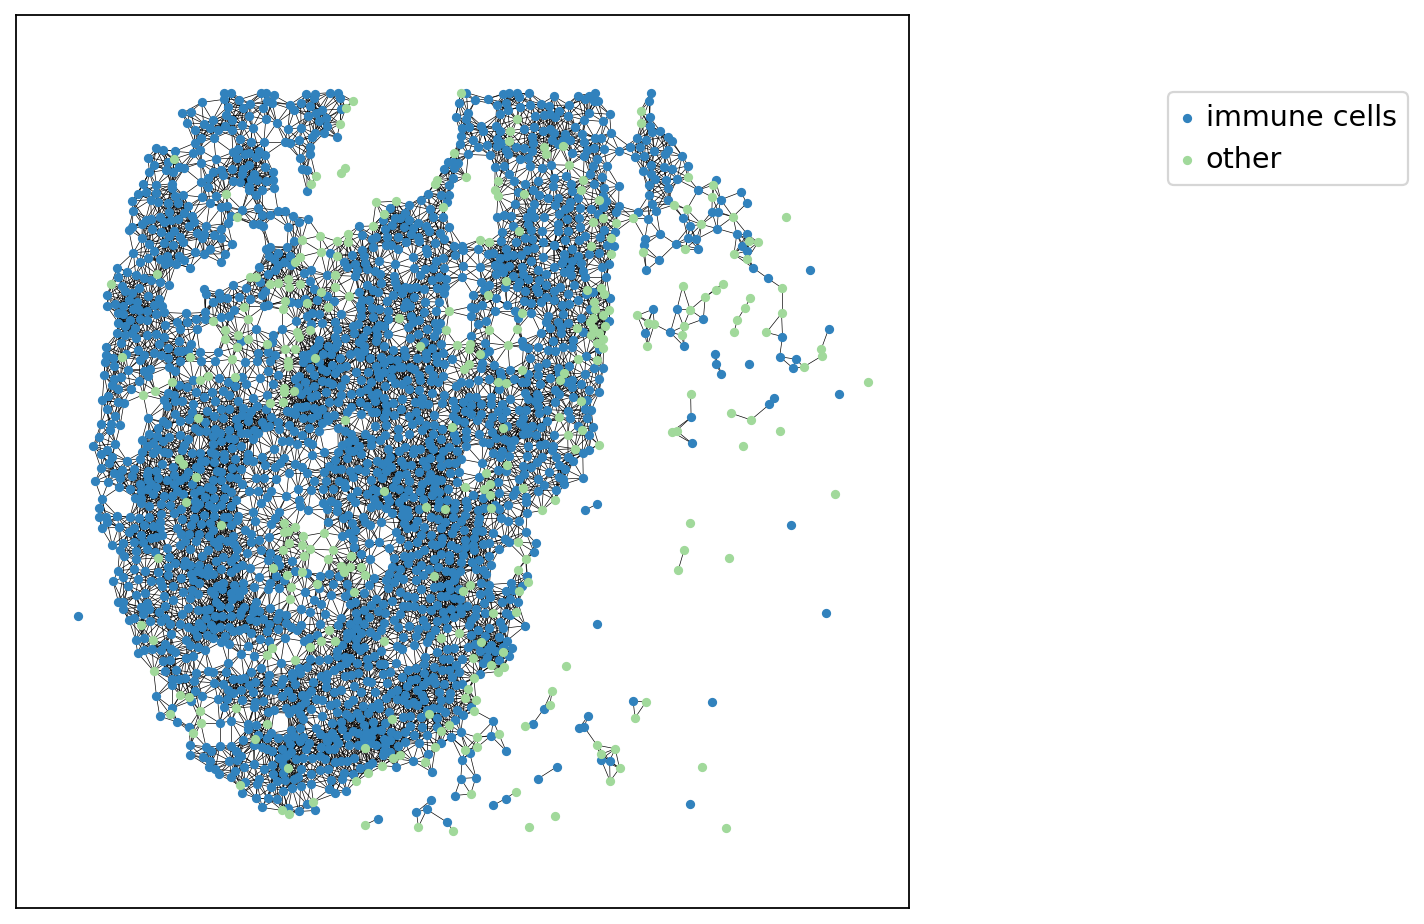

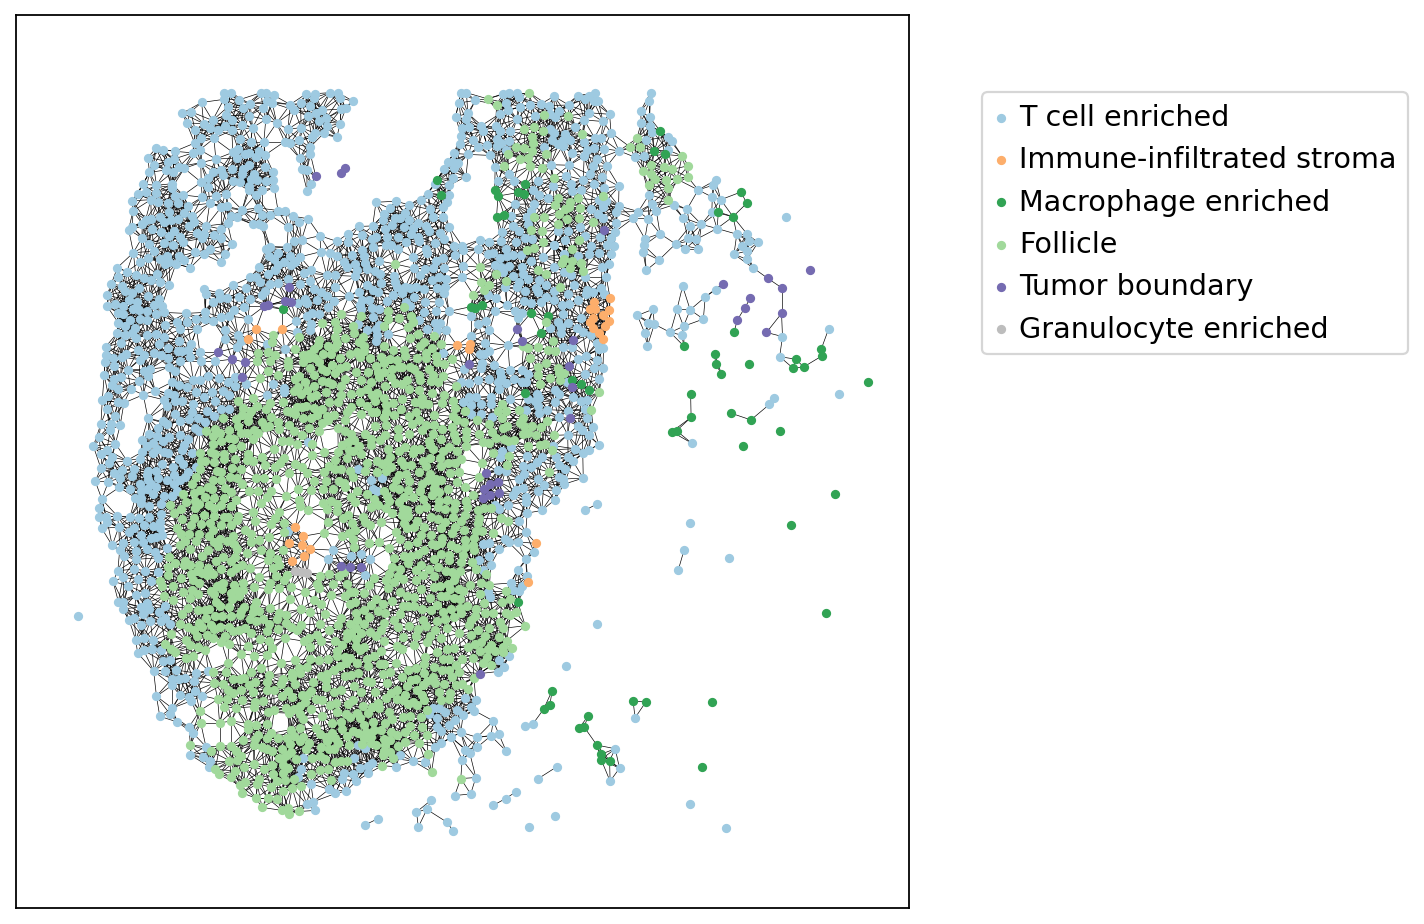

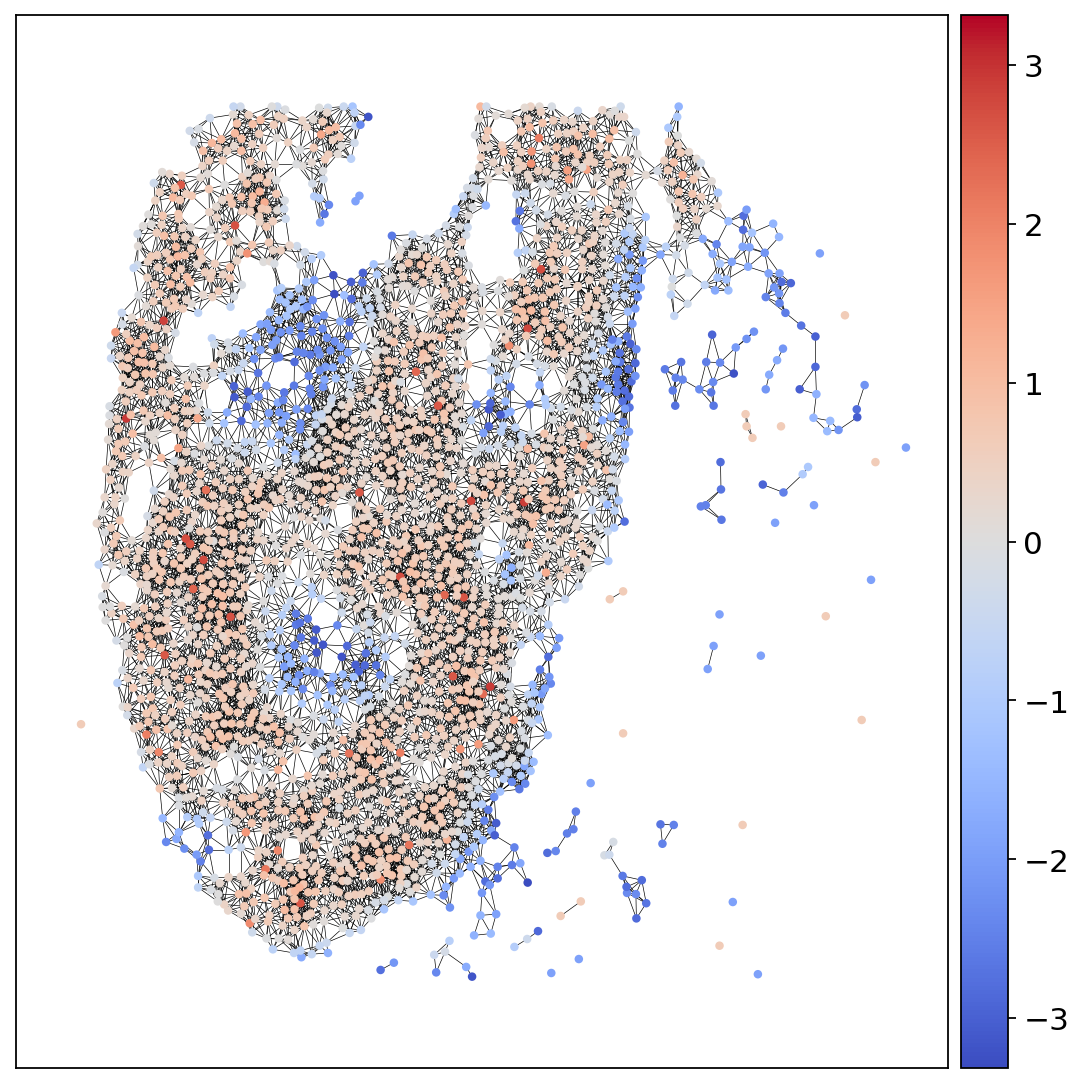

In [34]:
# here, we selected an  patient belonging to class CLR (i.e. grade 1)

img_idx = 40
patient = 11

# plot spatial graph using cell type labels, neighborghood regions and gradients

interpreter_fine.plot_graph(img_idx)
interpreter.plot_graph(img_idx)
interpreter.plot_graph(img_idx, 
                       neighborhood=True)
interpreter.plot_overall_gradient_on_graph(img_idx, 
                                           layer="input", 
                                           feature_space="celltype")

Note: the neighboods were defined in the dataset original publication